In [29]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os

In [510]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.ROHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 6, 2)
    mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [511]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mc = H2_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [167]:
nstates = 3
mcs = [copy.copy(mc) for i in range(nstates)]
for i in range(nstates):
        mcs[i].ci = mc.ci[i]

In [215]:
# Multi determinant boson new gradient
import importlib, bosonrecipes, bosonslater, bosonwftools
modules = [importlib, bosonrecipes, bosonslater, bosonwftools]
for m in modules:
    importlib.reload(m)

import importlib, slater, pyscftools,recipes, wftools, mc, slater, determinant_tools
modules = [importlib, slater, pyscftools,recipes, wftools, mc, slater, determinant_tools]
for m in modules:
    importlib.reload(m)


# import pyqmc.pyscftools as pyscftools

nconfig = 323
multi = True
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = ci_checkfile)
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None

wf = slater.Slater(mol, mf, mc=mcc)

In [217]:
wf._det_map

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
       [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
        4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [269]:
nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf.recompute(configs)
phib.shape

(1000,)

In [270]:
wf.parameters["det_coeff"]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [271]:
updets = wf._dets[0][:, :, wf._det_map[0]]
dndets = wf._dets[1][:, :, wf._det_map[1]]
updets.shape

(2, 1000, 36)

In [299]:
import pyqmc.gpu as gpu
upref = gpu.cp.amax(updets[1]).real
dnref = gpu.cp.amax(dndets[1]).real
phases = updets[0] * dndets[0]
logvals = updets[1] - upref + dndets[1] - dnref
phases = updets[0] * dndets[0]
wf_vals = phases * gpu.cp.exp(logvals)
    
wf_val = gpu.cp.einsum("id->i", phases * gpu.cp.exp(logvals)) # no def coeff
wf_sign = np.nan_to_num(wf_val / gpu.cp.abs(wf_val))
wf_logval = np.nan_to_num(gpu.cp.log(gpu.cp.abs(wf_val)) + upref + dnref)

In [320]:
wf_val.shape

(1000,)

In [306]:
ref = np.max(wf_vals, axis=0)
denominator = np.sum(np.exp(2 * (wf_vals - ref)), axis=0)
normalized_values = phases * np.exp(wf_vals - ref)

In [307]:
np.einsum(  # shape (wf, wf)
        "ik,jk->ij", normalized_values.conj(), normalized_values / denominator
    ) / len(ref)

array([[ 9.92799810e-04, -1.96621412e-06, -1.73534032e-05, ...,
        -1.80802805e-05,  2.76135509e-06, -7.82376785e-05],
       [-1.96621412e-06,  9.98282688e-04,  1.36660696e-04, ...,
         1.15255968e-04,  5.24283632e-06,  9.15516640e-07],
       [-1.73534032e-05,  1.36660696e-04,  1.00194851e-03, ...,
         1.19120366e-04,  2.83398141e-05,  2.72423929e-05],
       ...,
       [-1.80802805e-05,  1.15255968e-04,  1.19120366e-04, ...,
         9.46000350e-04,  2.27737256e-05, -4.59696216e-04],
       [ 2.76135509e-06,  5.24283632e-06,  2.83398141e-05, ...,
         2.27737256e-05,  1.08526981e-03,  3.05856605e-04],
       [-7.82376785e-05,  9.15516640e-07,  2.72423929e-05, ...,
        -4.59696216e-04,  3.05856605e-04,  1.06158893e-03]])

In [347]:
weight = np.exp(-2 * (wf_vals[:, np.newaxis] - wf_vals))
weight = 1.0 / np.sum(weight, axis=1)

In [348]:
weight.shape

(1000, 36)

In [439]:
psi_i = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), dndets[0], np.exp(dndets[1]))
rho = np.sum(psi_i**2, axis=1)
rho.shape

(1000,)

<Axes: >

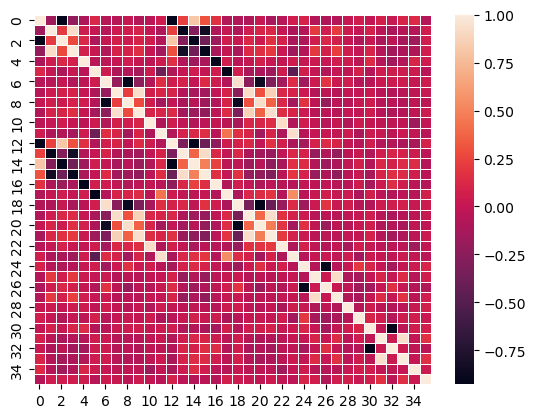

In [445]:
nup = np.einsum('ni, ni, nj, nj->nij', updets[0], np.exp(updets[1]), updets[0], np.exp(updets[1]))
ndn = np.einsum('ni, ni, nj, nj->nij', dndets[0], np.exp(dndets[1]), dndets[0], np.exp(dndets[1]))

psi_i = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), dndets[0], np.exp(dndets[1]))
rho = np.sum(psi_i**2, axis=1)

ovlp_ij  = nup * ndn 
nom = np.einsum('nij, n->ij', ovlp_ij, rho)

d1 = np.einsum('ni, ni, n->i', psi_i, psi_i, rho)
d  = np.sqrt(np.einsum('i, j->ij', d1, d1))

ovlp = nom/d
import seaborn as sns
sns.heatmap(ovlp,  linewidths=.5)

In [402]:
a = np.einsum('ni, nj->nij', psi_i, psi_i)
a.shape

(1000, 36, 36)

In [396]:
import seaborn as sns
sns.heatmap(np.mean(nom, axis=0),  linewidths=.5)

IndexError: Inconsistent shape between the condition and the input (got (36, 1) and (36,))

In [372]:
psi_i = np.einsum('ni, ni, ni, ni->ni', np.exp(updets[1]), np.exp(dndets[1]), np.exp(updets[1]), np.exp(dndets[1]))
psi_i.shape

(1000, 36)

In [373]:
rho = np.sum(psi_i, axis=1)


In [374]:
psi_ij = np.einsum('ni, nj->nij', psi_i, psi_i)
psi_ij.shape

(1000, 36, 36)

<Axes: >

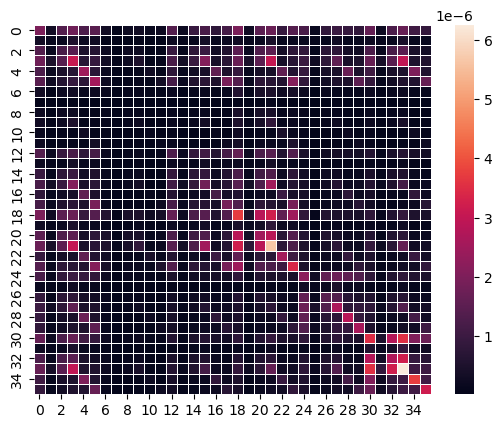

In [390]:
import seaborn as sns
sns.heatmap(np.mean(psi_ij, axis=0),  linewidths=.5)

In [382]:
div = np.mean(np.einsum('nij, n->nij', psi_ij, rho), axis=0)
div.shape

(36, 36)

In [383]:
tr = np.diag(div)

In [384]:
denom = np.sqrt(np.einsum('i,j->ij', tr, tr))
denom.shape

(36, 36)

In [385]:
s = div/denom

<Axes: >

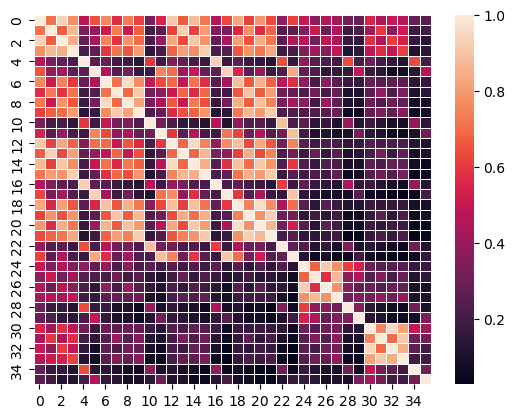

In [386]:
import seaborn as sns
sns.heatmap(s,  linewidths=.5)

In [387]:
s

array([[1.        , 0.70849012, 0.93912981, ..., 0.4660311 , 0.28946448,
        0.25315533],
       [0.70849012, 1.        , 0.66822101, ..., 0.51766597, 0.17892719,
        0.19817627],
       [0.93912981, 0.66822101, 1.        , ..., 0.53810305, 0.1710532 ,
        0.12717434],
       ...,
       [0.4660311 , 0.51766597, 0.53810305, ..., 1.        , 0.19705413,
        0.19416944],
       [0.28946448, 0.17892719, 0.1710532 , ..., 0.19705413, 1.        ,
        0.31302682],
       [0.25315533, 0.19817627, 0.12717434, ..., 0.19416944, 0.31302682,
        1.        ]])

In [280]:
nsum = np.sum(nii*nii, axis=1)

In [281]:
nii = np.einsum('ni, ni, ni, ni->ni', nii, nsum)

ValueError: operands could not be broadcast together with shapes (1000,36) (1000,) 

In [222]:
up_zero = wf._dets[0][:, :, [0]]
up_one = wf._dets[0][:, :, [1]]

dn_zero = wf._dets[1][:, :, [0]]
dn_one = wf._dets[1][:, :, [1]]

v = determinant_tools.compute_value(
            up_zero, up_zero, [1]
        )
phi_B = np.exp(phib)
# phi_B = np.ones(100000)
# val = v[0] * np.exp(v[1])/phi_val
np.average(val)

0.024797903712040926

In [223]:
up_zero.shape

(2, 1000, 1)

In [195]:
updets = wf._dets[0][:, :, wf._det_map[0]]
dndets = wf._dets[1][:, :, wf._det_map[1]]

In [196]:
# phi_val.shape

<Axes: >

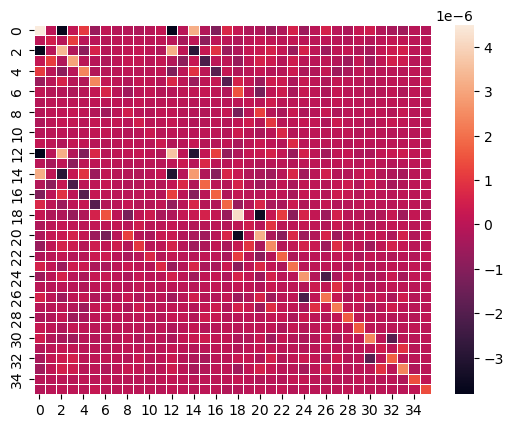

In [212]:
import matplotlib.pyplot as plt
nup = np.einsum('ni, ni, nj, nj, n->nij', updets[0], np.exp(updets[1]), updets[0], np.exp(updets[1]), phi_B)
ndn = np.einsum('ni, ni, nj, nj, n->nij', dndets[0], np.exp(dndets[1]), dndets[0], np.exp(dndets[1]), phi_B)
nb = np.sum(phi_B*phi_B, axis=0)
s = np.average(nup*ndn/nb, axis=0)
import seaborn as sns
sns.heatmap(s,  linewidths=.5)

In [204]:
np.sum(phi_B**2/nb)

1.0

In [57]:
dt1 = wf._dets[0][:, :, [0]]
dt2 = wf._dets[0][:, :, [1]]
sign, val = determinant_tools.compute_value(
            dt1, dt1, [1]
        )
valr = np.exp(val)
np.sum(sign*valr)

247.97903712040926

In [47]:
wf._det_map[0]

array([0, 0, 1, 1])

In [48]:
wf._det_map[1]

array([0, 1, 0, 1])

In [6]:
nconfig = 100
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
signb, phib = wfb.recompute(configs)
signs, phis = wfs.recompute(configs)

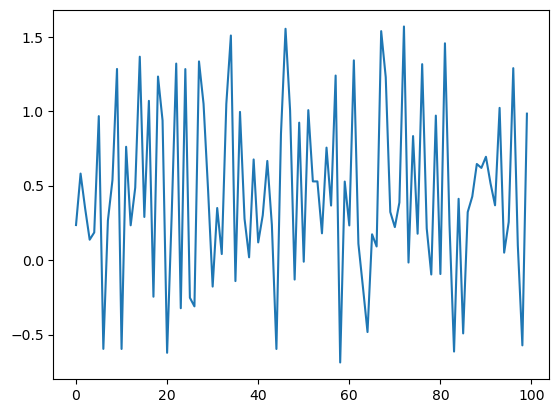

In [7]:
# Difference in values
plt.plot(phib-phis)

In [8]:
e=0
gradb, _, _ = wfb.gradient_value(e, configs.electron(e))
grads, _, _ = wfs.gradient_value(e, configs.electron(e))

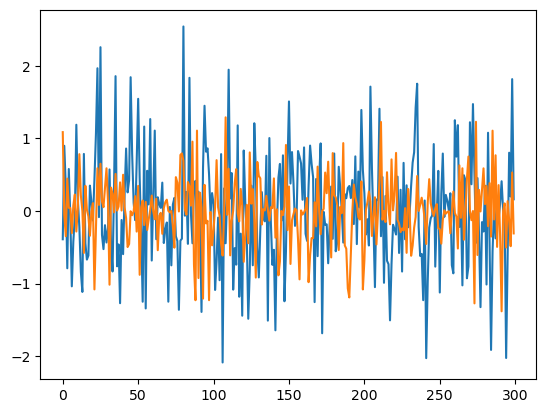

In [9]:
# Differnce in gradients
plt.plot(gradb.flatten())
plt.plot(gradb.flatten()-grads.flatten())

In [10]:
gradbr, _ = wfb.gradient_value_real(e, configs.electron(e))
gradbl, _, _ = wfb.gradient_value_log(e, configs.electron(e))

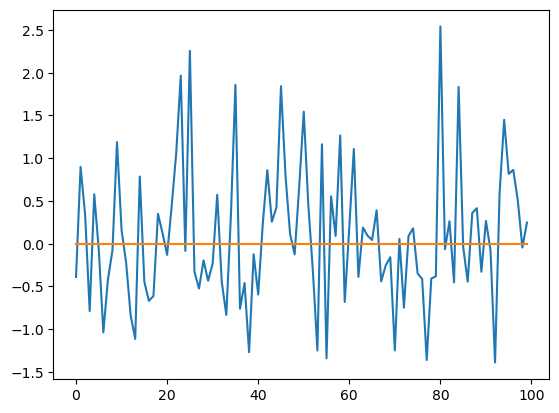

In [11]:
# check between the real and log gradients
idx = 0
plt.plot(gradbl[idx])
plt.plot(gradbl[idx]-gradbr[idx]/np.exp(phib))

In [534]:
import h5py 
f = h5py.File("abvmc.hdf5", "r")

In [535]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_d1', 'excitationsovlp_nom', 'excitationswf_val', 'nconfig']>

(100, 9, 9)


<Axes: >

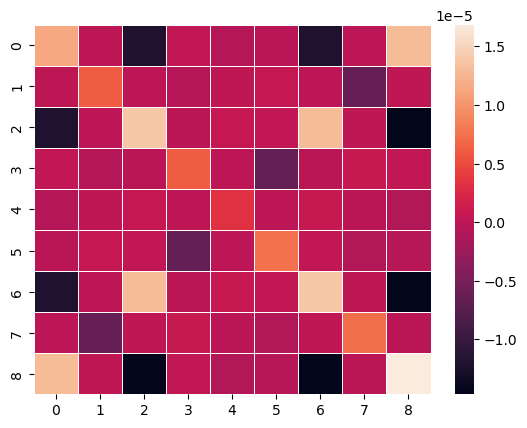

In [536]:
import seaborn as sns

nom=f['excitationsovlp_nom']
print(nom.shape)
nom_avg = np.average(nom, axis=0)
sns.heatmap(nom_avg,  linewidths=.5)

(100, 9)


<Axes: >

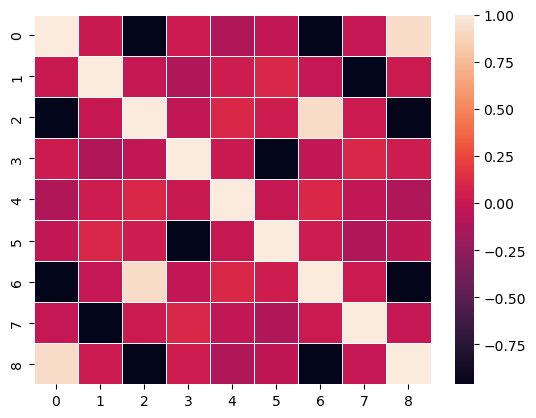

In [537]:
d1=f['excitationsovlp_d1']
print(d1.shape)

d1_avg = np.average(d1, axis=0)
denom = np.einsum('i, j->ij', d1_avg, d1_avg)
denom_avg = np.sqrt(denom)
res = nom_avg/denom_avg
sns.heatmap(res,  linewidths=.5)


In [523]:
denom.shape

(90, 90)